<a href="https://colab.research.google.com/github/vmavis/colab/blob/main/image_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Preparation and Preprocessing

Google drive is mounted so the files that have been uploaded to our drive can be accessed. Accessing the images through drive is way faster compared to uploading them to session storage or directly to our code because we do not need to keep re-uploading them.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


As they are both placed in seperate zip files, we need to unzip them first. For easier computation, the files need to be in seperate folders when unzipped and placed in session storage so they can be accessed easily.

In [ ]:
import zipfile

!unzip '/content/drive/MyDrive/images.zip'

Streaming output truncated to the last 5000 lines.
  inflating: images/119079_sat_71.jpg  
  inflating: images/119079_sat_72.jpg  
  inflating: images/119079_sat_73.jpg  
  inflating: images/119079_sat_77.jpg  
  inflating: images/119079_sat_78.jpg  
  inflating: images/119079_sat_80.jpg  
  inflating: images/119079_sat_81.jpg  
  inflating: images/119079_sat_87.jpg  
  inflating: images/119079_sat_88.jpg  
  inflating: images/122104_sat_00.jpg  
  inflating: images/122104_sat_01.jpg  
  inflating: images/122104_sat_03.jpg  
  inflating: images/122104_sat_04.jpg  
  inflating: images/122104_sat_11.jpg  
  inflating: images/122104_sat_13.jpg  
  inflating: images/122104_sat_14.jpg  
  inflating: images/122104_sat_15.jpg  
  inflating: images/122104_sat_16.jpg  
  inflating: images/122104_sat_20.jpg  
  inflating: images/122104_sat_21.jpg  
  inflating: images/122104_sat_22.jpg  
  inflating: images/122104_sat_23.jpg  
  inflating: images/122104_sat_24.jpg  
  inflating: images/122104_sa

In [ ]:
!unzip '/content/drive/MyDrive/masks.zip'

Streaming output truncated to the last 5000 lines.
  inflating: masks/119079_mask_71.jpg  
  inflating: masks/119079_mask_72.jpg  
  inflating: masks/119079_mask_73.jpg  
  inflating: masks/119079_mask_77.jpg  
  inflating: masks/119079_mask_78.jpg  
  inflating: masks/119079_mask_80.jpg  
  inflating: masks/119079_mask_81.jpg  
  inflating: masks/119079_mask_87.jpg  
  inflating: masks/119079_mask_88.jpg  
  inflating: masks/122104_mask_00.jpg  
  inflating: masks/122104_mask_01.jpg  
  inflating: masks/122104_mask_03.jpg  
  inflating: masks/122104_mask_04.jpg  
  inflating: masks/122104_mask_11.jpg  
  inflating: masks/122104_mask_13.jpg  
  inflating: masks/122104_mask_14.jpg  
  inflating: masks/122104_mask_15.jpg  
  inflating: masks/122104_mask_16.jpg  
  inflating: masks/122104_mask_20.jpg  
  inflating: masks/122104_mask_21.jpg  
  inflating: masks/122104_mask_22.jpg  
  inflating: masks/122104_mask_23.jpg  
  inflating: masks/122104_mask_24.jpg  
  inflating: masks/122104_mas

All the required libraries and functions are imported first. Further need of other libraries and functions may require us to import them seperately.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

import torch
from tensorflow import keras
from keras import datasets, layers, models
from keras.utils import np_utils
from keras.metrics import MeanIoU

import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

import glob

A directory to each folder is defined first.

In [ ]:
img_dir = '/content/images/'
msk_dir = '/content/masks/'

The paths are then sorted so each image will have the correct corresponding mask. By using os.listdir, Python will check all files contained in the defined directory.

The parent path, which is the folder directory, and the file name are combined. They are then kept in a seperate list for each folder.

In [ ]:
import os

img_paths = sorted(
    [
        os.path.join(img_dir, fname)
        for fname in os.listdir(img_dir)
    ]
)

msk_paths = sorted(
    [
        os.path.join(msk_dir, fname)
        for fname in os.listdir(msk_dir)
    ]
)

The total number of files is printed to check how many files are present in each list. We then check if each image has the correct corresponding mask.

In [ ]:
print("Number of images:", len(img_paths))
print("Number of masks:", len(msk_paths))

for input_path, target_path in zip(img_paths[:5], msk_paths[:5]):
    print(input_path, "|", target_path)

Number of images: 5108
Number of masks: 5108
/content/images/10452_sat_08.jpg | /content/masks/10452_mask_08.jpg
/content/images/10452_sat_18.jpg | /content/masks/10452_mask_18.jpg
/content/images/111335_sat_00.jpg | /content/masks/111335_mask_00.jpg
/content/images/111335_sat_01.jpg | /content/masks/111335_mask_01.jpg
/content/images/111335_sat_02.jpg | /content/masks/111335_mask_02.jpg


# Bulding Data Set

The lists are split into training and testing sets. 70% will be allocated for the training sets and the rest will be allocated for the testing sets. A validation set is not needed because the testing sets can be used for validation.

In [ ]:
train_img_paths, test_img_paths = img_paths[:int(0.7*len(img_paths))], img_paths[int(0.7*len(img_paths)):]
train_msk_paths, test_msk_paths = msk_paths[:int(0.7*len(msk_paths))], msk_paths[int(0.7*len(msk_paths)):]

The number of paths in each set is checked to see if the image and mask paths have been split correctly.

In [ ]:
print("Train image size: {}\nTest image size: {}".format(len(train_img_paths), len(test_img_paths)))
print("Train mask size: {}\nTest mask size: {}".format(len(train_msk_paths), len(test_msk_paths)))

Train image size: 3575
Test image size: 1533
Train mask size: 3575
Test mask size: 1533


The first four images are from the training sets and the next four images are from the testing sets. They are printed into subplots so they can be printed in stacks and io is used to read the image and mask paths.

<Figure size 432x288 with 0 Axes>

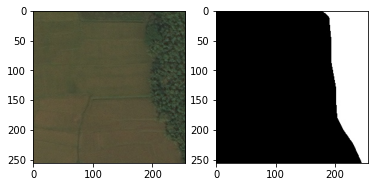

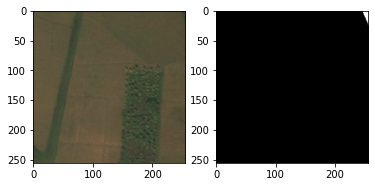

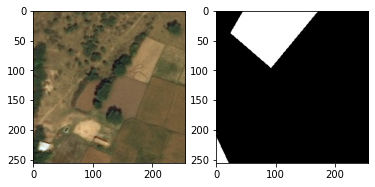

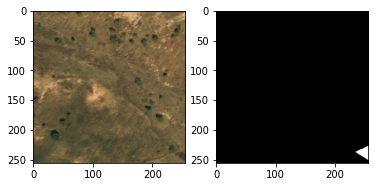

In [ ]:
from skimage import io

plt.figure()

f, axarr = plt.subplots(1,2)
axarr[0].imshow(io.imread(train_img_paths[0]))
axarr[1].imshow(io.imread(train_msk_paths[0]))

f, axarr = plt.subplots(1,2)
axarr[0].imshow(io.imread(train_img_paths[1]))
axarr[1].imshow(io.imread(train_msk_paths[1]))

f, axarr = plt.subplots(1,2)
axarr[0].imshow(io.imread(test_img_paths[0]))
axarr[1].imshow(io.imread(test_msk_paths[0]))

f, axarr = plt.subplots(1,2)
axarr[0].imshow(io.imread(test_img_paths[1]))
axarr[1].imshow(io.imread(test_msk_paths[1]))

We use keras to build a sequence class so we can load & vectorize batches of data. Each image should have vector digits representation.

In [ ]:
from tensorflow import keras
import numpy as np
from tensorflow.keras.preprocessing.image import load_img

class Data(keras.utils.Sequence):

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)
            x[j] = img
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            y[j] = np.expand_dims(img, 2)
            y[j] -= 1
        return x, y

The desired image and batch sizes are defined first. As the default image size is 256, we will use it for our image size. The training image and mask paths are loaded as the training set, while the testing image and mask paths are loaded as the testing set.

In [ ]:
img_size = (256, 256)
batch_size = 64
train_gen = Data(batch_size, img_size, train_img_paths, train_msk_paths)
test_gen = Data(batch_size, img_size, test_img_paths, test_msk_paths)

# U-Net Architecture

U-Net is a modification of FCN (Fully Convolutional Network) developed for semantic segmentation tasks. It is a U-shaped encoder-decoder network which contains four encoder blocks and four decoder blocks that are connected by a bridge.
1. The encoder network halfs the spatial dimensions and doubles the number of feature channels at each encoder block. It learns an abstract representation of the input image through a sequence of the encoder blocks.
2. The decoder network doubles the spatial dimensions and halfs the number of feature channels. It is used to take the abstract representation and generate a semantic segmentation mask.

The architecture is shown below.

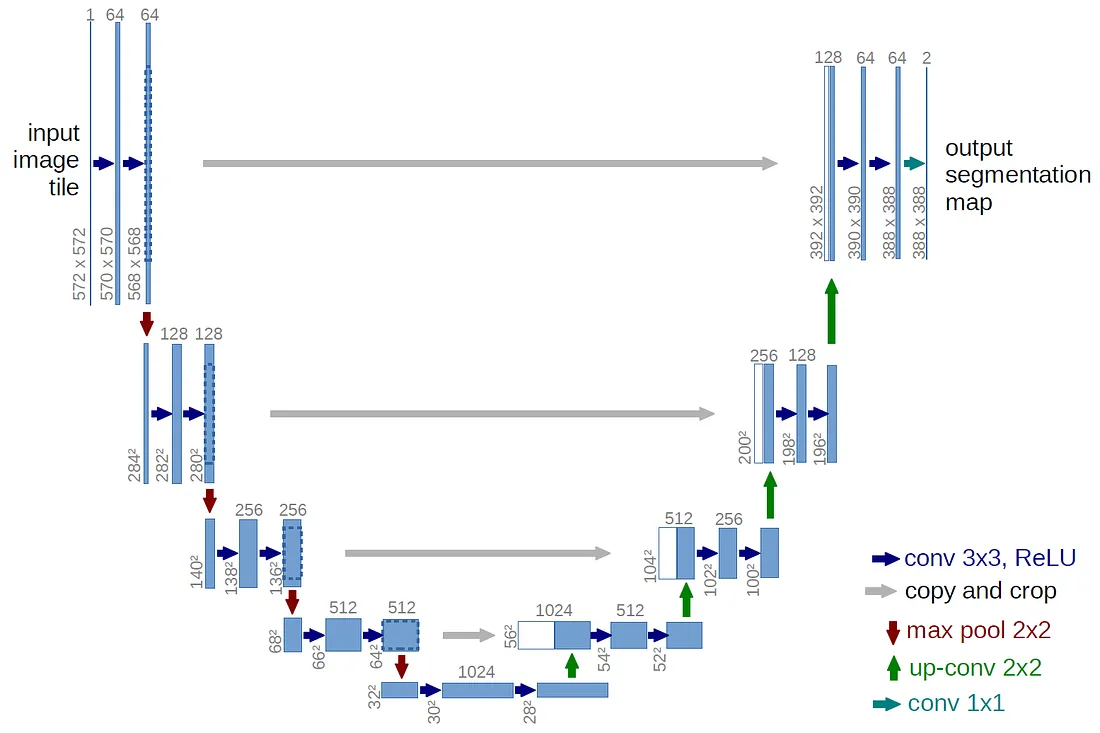

# U-Net Xception-Style Model

U-Net is the most commonly used architecture for semantic segmentation tasks. It usually yields good results and can be used on any data set. The creator of Keras, [François Chollet](https://https://twitter.com/fchollet), has developed a U-Net like model that can create almost identical mask predictions. He used a Keras data set to train and test the model. I wish to test if the model can yield good results if tested on a non-Keras data set.

A model is defined where it takes the image size as the main parameter. It has an entry block, containing convolutional, batch normalization, and ReLu activation layers. 3 identical blocks are then created to act as the encoder network and another 3 to act as the decoder network. The output is a per-pixel classification layer.

In [ ]:
def get_model(img_size):
    inputs = keras.Input(shape=img_size + (3,))

    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x

    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])
        previous_block_activation = x

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])
        previous_block_activation = x

    outputs = layers.Conv2D(3, 3, activation="softmax", padding="same")(x)

    model = keras.Model(inputs, outputs)
    return model

keras.backend.clear_session()

model = get_model(img_size)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

The model is compiled with Adam as the optimizer because it is efficient and does not require much memory. It is also compiled with binary cross entropy as the loss function as there are only 2 classes (image and mask).

In [ ]:
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=['accuracy'])

fitted = model.fit(train_gen, epochs=5, validation_data=test_gen)

Epoch 1/5
55/55 [==============================] - 83s 1s/step - loss: -749498752.0000 - accuracy: 0.0077 - val_loss: -5702643200.0000 - val_accuracy: 1.2439e-07
Epoch 2/5
55/55 [==============================] - 67s 1s/step - loss: -1883161100288.0000 - accuracy: 1.3005e-08 - val_loss: -15795763544064.0000 - val_accuracy: 1.4512e-07
Epoch 3/5
55/55 [==============================] - 68s 1s/step - loss: -285046208462848.0000 - accuracy: 1.9940e-07 - val_loss: -1287569052532736.0000 - val_accuracy: 9.3294e-08
Epoch 4/5
55/55 [==============================] - 67s 1s/step - loss: -10677112604196864.0000 - accuracy: 1.9767e-06 - val_loss: -21460392504983552.0000 - val_accuracy: 1.9177e-06
Epoch 5/5
55/55 [==============================] - 65s 1s/step - loss: -175596525261422592.0000 - accuracy: 1.7855e-05 - val_loss: -293645127321124864.0000 - val_accuracy: 1.0791e-05


The model shows that the training and validation losses decrease as the number of epochs increases. It also shows that the training and validation accuraciess decrease as the number of epochs increases. This proves that we do not need to use a high number of epochs.

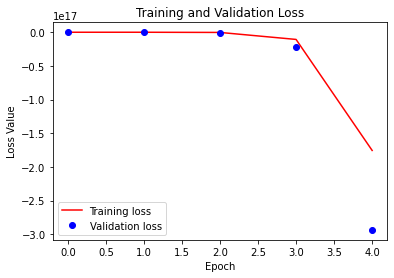

In [ ]:
loss = fitted.history['loss']
val_loss = fitted.history['val_loss']

plt.figure()
plt.plot(fitted.epoch, loss, 'r', label='Training loss')
plt.plot(fitted.epoch, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()
plt.show()

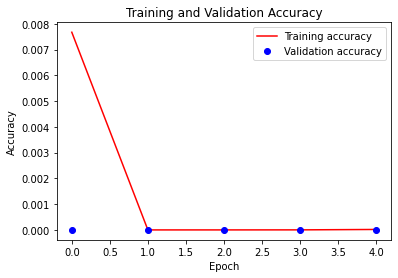

In [ ]:
acc = fitted.history['accuracy']
val_acc = fitted.history['val_accuracy']

plt.figure()
plt.plot(fitted.epoch, acc, 'r', label='Training accuracy')
plt.plot(fitted.epoch, val_acc, 'bo', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

The testing set is predicted using the model that has been fitted.

In [ ]:
test_pred = model.predict(test_gen)

23/23 [==============================] - 7s 301ms/step


A function to visualise the predicted mask is defined as follows.

Argmax will only take the largest values of the numpy array, while expand_dims will expand the shape of the numpy array. As the predicted mask is still in vector, we use a Keras function to convert it to image.

In [ ]:
def display_mask(i):
    mask = np.argmax(test_pred[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = keras.preprocessing.image.array_to_img(mask)
    display(img)

# U-Net Xception-Style Model with Attention Layers

The model is similar to the previous one, only with additional attention layers. Hard attention makes a hard (values are either 0 or 1) decision on which input to focus on, while soft attention makes a soft decision (values lie in the range of 0 and 1). However, as this model does not have input focuses, it is hard to determine which one is being used.

In [ ]:
def get_model1(img_size):
    inputs = keras.Input(shape=img_size + (3,))

    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Attention()(x)

    previous_block_activation = x

    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.Attention()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.Attention()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])
        previous_block_activation = x

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.Attention()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.Attention()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])
        previous_block_activation = x

    outputs = layers.Conv2D(3, 3, activation="softmax", padding="same")(x)

    model = keras.Model(inputs, outputs)
    return model

keras.backend.clear_session()

# Build model
model1 = get_model(img_size)
model1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

Like the previous model, this one is compiled with Adam as the optimizer  binary cross entropy as the loss function.

In [ ]:
model1.compile(optimizer="adam", loss="binary_crossentropy", metrics=['accuracy'])

fitted1 = model1.fit(train_gen, epochs=5, validation_data=test_gen)

Epoch 1/5
55/55 [==============================] - 71s 1s/step - loss: -38354423025500160.0000 - accuracy: 0.0335 - val_loss: -55198571795841024.0000 - val_accuracy: 0.0310
Epoch 2/5
55/55 [==============================] - 69s 1s/step - loss: -123062418032033792.0000 - accuracy: 0.0360 - val_loss: -228102414555676672.0000 - val_accuracy: 0.0308
Epoch 3/5
55/55 [==============================] - 68s 1s/step - loss: -485971529453010944.0000 - accuracy: 0.0384 - val_loss: -812963229536878592.0000 - val_accuracy: 0.0330
Epoch 4/5
55/55 [==============================] - 67s 1s/step - loss: -2067300388154900480.0000 - accuracy: 0.0408 - val_loss: -3922997839398961152.0000 - val_accuracy: 0.0327
Epoch 5/5
55/55 [==============================] - 68s 1s/step - loss: -8359642981073944576.0000 - accuracy: 0.0428 - val_loss: -16532193063565524992.0000 - val_accuracy: 0.0328


The model shows that the training and validation losses decrease as the number of epochs increases. However, it shows that the training and validation accuraciess increase as the number of epochs increases. This indicates that we may increase the number of epochs for the model to yield better accuracy.

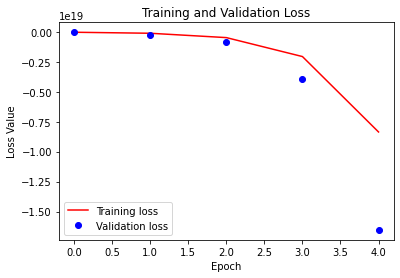

In [ ]:
loss1 = fitted1.history['loss']
val_loss1 = fitted1.history['val_loss']

plt.figure()
plt.plot(fitted1.epoch, loss1, 'r', label='Training loss')
plt.plot(fitted1.epoch, val_loss1, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()
plt.show()

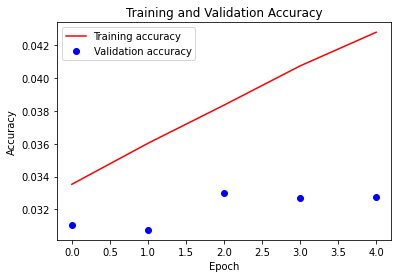

In [ ]:
acc1 = fitted1.history['accuracy']
val_acc1 = fitted1.history['val_accuracy']

plt.figure()
plt.plot(fitted1.epoch, acc1, 'r', label='Training accuracy')
plt.plot(fitted1.epoch, val_acc1, 'bo', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
test_pred1 = model1.predict(test_gen)

23/23 [==============================] - 8s 352ms/step


In [ ]:
def display_mask1(i):
    mask = np.argmax(test_pred1[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = keras.preprocessing.image.array_to_img(mask)
    display(img)

# Mask Differences

We assign a random number generator to a variable so we can have different images every time we run the code.

In [ ]:
import random

i = random.randint(0,100)

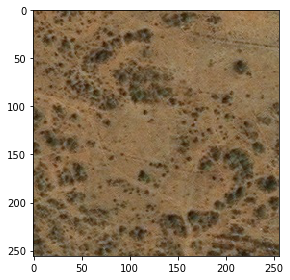

In [ ]:
io.imshow(io.imread(test_img_paths[i]))

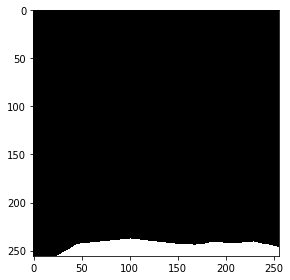

In [ ]:
io.imshow(io.imread(test_msk_paths[i]))

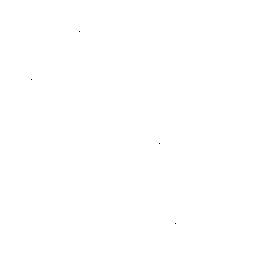

In [ ]:
display_mask(i)

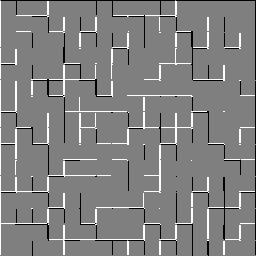

In [ ]:
display_mask1(i)

# Conclusion

Both models yield extremely low accuracies and do not make good predicted masks. However, the U-Net Xception-Style with attention shows better prediction as it does not show a plain white image as the output. Its accuracies also keep on increasing, even if only by a litte. Further experiments can be done to modify the second model to see if it can yield high accuracies and make better predicted masks.

# References


The source code is taken from the following link: https://keras.io/examples/vision/oxford_pets_image_segmentation/. It attempts to create a U-Net like model to perform segmentation tasks. It was created by François Chollet on March 20, 2019 and last updated on April 20, 2020.

U-Net Architecture:

https://medium.com/analytics-vidhya/what-is-unet-157314c87634 (written by Nikhil Tomar on Jan 19, 2021)


Attention U-Net:

Ronneberger, Olaf, Fischer, Philipp, & Brox, Thomas. (2015). *U-Net: Convolutional Networks for Biomedical Image Segmentation*. 	[arXiv:1505.04597](https://arxiv.org/abs/1505.04597).

Oktay, Ozan, Schlemper, Jo, Zhu, Yukun, Papandreou, George, Schroff, Florian, & Adam, Hartwig. (2018). *Attention U-Net: Learning Where to Look for the Pancreas*. [arXiv:1804.03999](https://arxiv.org/abs/1804.03999).